The project aims to identify invalid and misused vote rates through raw cast votes data in an election using RCV, to be compared to a global norm of invalid rates in other voting systems. The code includes cleaning code for generating the variables for the types of invalid and misused vote patterns. Then, summary tables and visualizations are presented to get a sense of the distribution of invalid and misused vote rates.  
**This analysis is part of a larger research project on voter comprehension of ranked choice voting.**

The Utah city council data can be found on [https://doi.org/10.7910/DVN/04LOQX](https://doi.org/10.7910/DVN/04LOQX).  
The global invalid vote rates can be found on [https://www.idea.int/data-tools/data/question?question_id=9117&database_theme=293](https://www.idea.int/data-tools/data/question?question_id=9117&database_theme=293).

# Utah City Council Cast Votes Data

## 1. Setting up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os

In [2]:
# read in dataframes
df_wh = pd.read_csv('WoodlandHills_11022021_CityCouncil.csv')
df_sv = pd.read_csv('Springville_11022021_CityCouncil4yr.csv')
df_vy = pd.read_csv('Vineyard_11022021_CityCouncil.csv')
df_genola = pd.read_csv('Genola_11022021_CityCouncil.csv')
df_moab = pd.read_csv('Moab_11022021_CityCouncil.csv')
df_lehi = pd.read_csv('Lehi_11022021_CityCouncil.csv')
dfs = [df_wh, df_sv, df_vy, df_genola, df_moab, df_lehi]
cities = ['Woodland Hills', 'Springville', 'Vineyard', 'Genola', 'Moab', 'Lehi']

## 2. Cleaning

In [3]:
# cleaning code
df_moab.rename(columns={'Vote':'Index'}, inplace=True)  # to match others

def skipped_ranking(x, ranks):
    '''determines if the voter skips a rank then proceeds to name a candidate in one of the following ranks'''
    if x['overvote']==1 or x['candidate_multiple_ranks']==1:
        return 0
    else:
        combined_ranks = x['combined_ranks']
        if 'skipped' in combined_ranks:
            first_skipped_index = combined_ranks.index('skipped')
            if first_skipped_index==len(ranks)-1:  # if first skip is the last element
                return 0
            else:
                rest_of_list = combined_ranks[first_skipped_index+1:]  # get ranks after first skip
                if len(set(rest_of_list)) == 1 and 'skipped' in set(rest_of_list):  # if the rest are skip
                    return 0
                else:  # something after skip is in the rest
                    return 1
        else: # if no skip then return 0
            return 0

def candidate_multiple_ranks(x):
    '''determines if a candidate in mentioned in more than 1 rank'''
    if x['overvote']==1:
        return 0
    else:
        combined_ranks = x['combined_ranks']
        remove_skips = [i for i in combined_ranks if i!='skipped']
        count_elements = [remove_skips.count(i) for i in remove_skips]
        test_list = [i for i in count_elements if i>1]
        if len(test_list) > 0:  # if there are elements that have more than 1 count in the remove_skips list
            return 1
        else:
            return 0

def ballot_misuse_type(x):
    if x['overvote']==1:
        return 'Overvote'
    elif x['candidate_multiple_ranks']==1:
        return 'Candidate in Multiple Ranks'
    elif x['skipped_ranking']==1:
        return 'Skipped Ranking'
    elif x['undervote']==1:
        return 'Undervote'
    else:
        return None

def invalid_type(x):
    if x['overvote']==1:
        return 'Overvote'
    elif x['candidate_multiple_ranks']==1:
        return 'Candidate in multiple ranks'
    elif x['undervote']==1:
        return 'Undervote'
    else:
        return None

def cleaner(df):
    ranks = [i for i in df.columns if 'rank' in i]
    df['combined_ranks'] = df[ranks].apply(lambda x: ','.join(x).split(','), axis=1)
    df['overvote']  = (df[ranks] == 'overvote').any(axis=1).astype(int)
    df['candidate_multiple_ranks'] = df.apply(candidate_multiple_ranks, axis=1)
    df['skipped_ranking'] = df.apply(lambda x: skipped_ranking(x, ranks), axis=1)
    df['undervote'] = (df[ranks] == 'skipped').all(axis=1).astype(int)
    
    df['misuse_type'] = df.apply(ballot_misuse_type, axis=1)
    df['misuse'] = df[['skipped_ranking', 'candidate_multiple_ranks', 'overvote', 'undervote']].sum(axis=1)
    
    df['invalid_type'] = df.apply(invalid_type, axis=1)
    df['invalid'] = df[['candidate_multiple_ranks', 'overvote', 'undervote']].sum(axis=1)
    df.drop(columns=['Index', 'combined_ranks'], inplace=True)
    return df

for df in dfs:  # apply cleaning code
    df = cleaner(df)

for df, city in zip(dfs, cities):  # create city variable for merging
    df['city'] = city

# create merged df
df = pd.concat(dfs, axis=0)

In [4]:
# check for cleaning validity
def invalid_exclusive(dfs):
    '''ensures all dfs mutually exclusive invalid types, i.e. invalid binary column has no value greater than 1'''
    truths = []
    for df in dfs:
        truths.append(sum(df['invalid'].value_counts().index)==1)
    return sum(truths)==len(dfs)

invalid_exclusive(dfs)

True

## 3. Analysis

In [5]:
# votes and invalid votes across cities (& total)
summary = df.groupby('city').agg(
    Votes=('rank1', 'size'),  # the size of any column, the number of unique votes
    Overvotes=('overvote', 'sum'),
    candidate_multiple_ranks=('candidate_multiple_ranks', 'sum'),
    skipped_ranking=('skipped_ranking', 'sum'),
    Undervotes=('undervote', 'sum'),
    total_misused_ballots=('misuse', 'sum'),
    total_invalid_votes=('invalid', 'sum')
).reset_index(
    names='City Council'
).rename(columns = {
    'candidate_multiple_ranks':'Candidate in Multiple Ranks',
    'skipped_ranking':'Skipped Ranking',
    'total_misused_ballots':'Total Misused Votes',
    'total_invalid_votes':'Total Invalid Votes'
                   })

# create sum row
row = summary.sum()
row['City Council'] = 'Total'

# add sum row
summary = pd.concat([summary, pd.DataFrame(row).T], axis=0).set_index('City Council')
summary['Proportion Misused'] = summary['Total Misused Votes'] / summary['Votes']
summary['Proportion Invalid'] = summary['Total Invalid Votes'] / summary['Votes']

# # adjust data types
summary['Proportion Misused'] = summary['Proportion Misused'].astype(float).round(2)
summary['Proportion Invalid'] = summary['Proportion Invalid'].astype(float).round(2)
for i in list(summary.columns)[0:2]:
    summary[i] = summary[i].astype(int)
summary

,Votes,Overvotes,Candidate in Multiple Ranks,Skipped Ranking,Undervotes,Total Misused Votes,Total Invalid Votes,Proportion Misused,Proportion Invalid
City Council,,,,,,,,,
Genola,393,6,6,134,9,155,21,0.39,0.05
Lehi,11471,378,324,132,269,1103,971,0.10,0.08
Moab,1847,38,39,481,16,574,93,0.31,0.05
Springville,6307,175,136,64,160,535,471,0.08,0.07
Vineyard,1540,4,15,9,20,48,39,0.03,0.03
Woodland Hills,658,11,9,1,2,23,22,0.03,0.03
Total,22216,612,529,821,476,2438,1617,0.11,0.07


In [6]:
sr = summary.iloc[0:-1, 3]
pi = summary.iloc[0:-1, -1]
sr.corr(pi)

0.20200459862239584

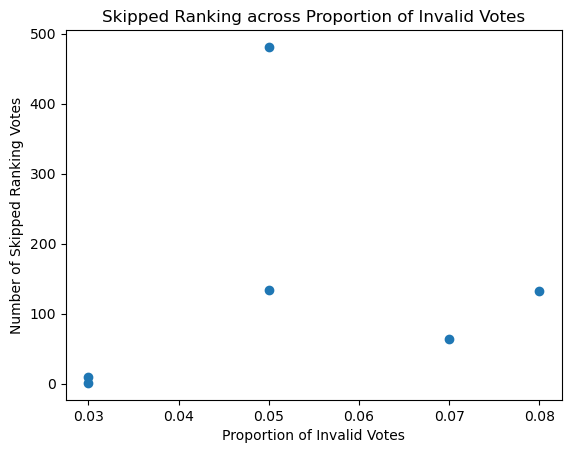

In [7]:
plt.scatter(pi, sr)
plt.xlabel('Proportion of Invalid Votes')
plt.ylabel('Number of Skipped Ranking Votes')
plt.title('Skipped Ranking across Proportion of Invalid Votes');

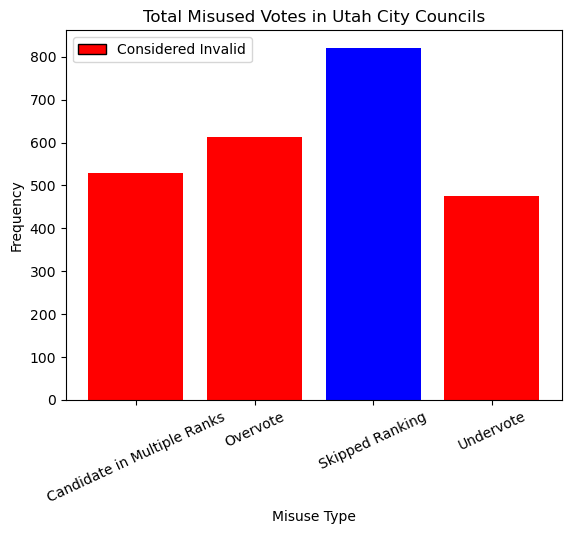

In [8]:
# total invalid votes bar plot
grouped = df.groupby('misuse_type').size()
colors = ['red' if i in [0, 1, 3] else 'blue' for i in range(len(grouped))]

# Create the bar plot
plt.bar(grouped.index, grouped.values, color=colors)

# Adding legend
custom_legend = [plt.Rectangle((0,0),1,1, color='red', ec='k')]

plt.legend(custom_legend, ['Considered Invalid'])

# Add labels and title
plt.xlabel('Misuse Type')
plt.ylabel('Frequency')
plt.xticks(rotation=25)
plt.title('Total Misused Votes in Utah City Councils')

# Show the plot
plt.show()

# IDEA Invalid Votes Data

## 1. Read-in Data

In [9]:
invalid_pres = pd.read_excel('idea_invalid_presidential.xlsx')
invalid_parl = pd.read_excel('idea_invalid_parliamentary.xlsx')

## 2. Cleaning

In [10]:
# remove percentage sign
def fixer(x):
    return float(x[:-1])

for i in [invalid_pres, invalid_parl]:
    i.iloc[:,-1] = i.iloc[:,-1].apply(lambda x: fixer(x))
    i.rename(columns={
        'Value (Numeric)':'invalid_percent'
    }, inplace=True)  # rename

# prepare for merging
invalid_pres['Election Type'] = ['Presidential' for i in range(len(invalid_pres))]
invalid_parl['Election Type'] = ['Parliamentary' for i in range(len(invalid_parl))]

# merge
merged = pd.concat([invalid_pres, invalid_parl], axis=0)

# convert to datetime
merged['Year'] = pd.to_datetime(merged['Year'], format='mixed', dayfirst=False)

## 3. Analysis

In [11]:
year_stats = merged.groupby('Election Type').agg(
    minyear = ('Year', 'min'),
    maxyear = ('Year', 'max'),
    medianyear = ('Year', 'median')
).rename(columns={
    'minyear':'Minimum Date', 
    'maxyear':'Maximum Date',
    'medianyear':'Median Date'

})
year_stats['Median Date'] = year_stats['Median Date'].dt.floor('D')
year_stats

,Minimum Date,Maximum Date,Median Date
Election Type,,,
Parliamentary,1958-11-30,2024-05-08,2020-01-01
Presidential,1951-05-06,2024-05-08,2016-05-17


In [12]:
inv_stats = merged.groupby('Election Type').agg(
    min_inv = ('invalid_percent', 'min'),
    max_inv = ('invalid_percent', 'max'),
    mean_inv = ('invalid_percent', 'mean'),
    std_inv = ('invalid_percent', 'std'),
    median_inv = ('invalid_percent', 'median')).applymap(lambda x: round(x,2))
inv_stats.columns = ['Minimum Invalid Percent', 'Maximum Invalid Percent',
                     'Mean Invalid Percent', 'Standard Deviation Invalid Percent',
                     'Median Invalid Percent']
inv_stats

,Minimum Invalid Percent,Maximum Invalid Percent,Mean Invalid Percent,Standard Deviation Invalid Percent,Median Invalid Percent
Election Type,,,,,
Parliamentary,0.01,25.83,3.79,4.25,2.49
Presidential,0.02,27.93,3.67,4.30,2.05


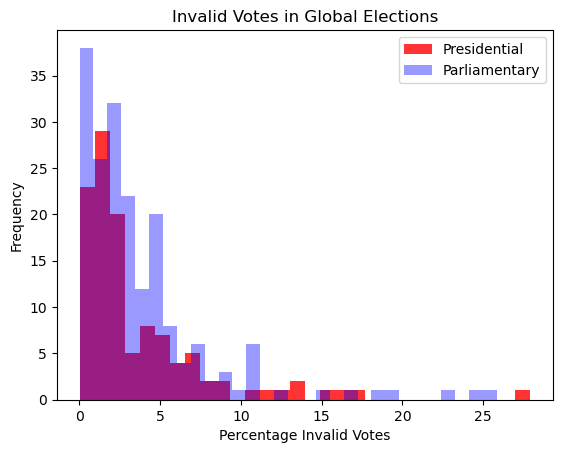

In [13]:
plt.hist(invalid_pres.iloc[:,-2], alpha=0.8, color='red', label='Presidential', bins=30)
plt.hist(invalid_parl.iloc[:,-2], alpha=0.4, color='blue', label='Parliamentary', bins=30)
plt.legend()
plt.xlabel('Percentage Invalid Votes')
plt.ylabel('Frequency')
plt.title('Invalid Votes in Global Elections');

In [14]:
idea_invalid_combined = list(invalid_pres['invalid_percent']) + list(invalid_parl['invalid_percent'])

def permutation_test(group1, group2, num_permutations=10000):
    # Compute the observed difference in means
    observed_diff = np.mean(group1) - np.mean(group2)
    
    # Combine the data
    combined = np.concatenate((group1, group2))
    
    # Initialize a counter for the number of times the permuted test statistic is as extreme as the observed
    extreme_count = 0
    
    # Perform the permutations
    for _ in range(num_permutations):
        # Shuffle the combined data
        np.random.shuffle(combined)
        
        # Split the shuffled data into two groups
        new_group1 = combined[:len(group1)]
        new_group2 = combined[len(group1):]
        
        # Compute the difference in means for the permuted data
        permuted_diff = np.mean(new_group1) - np.mean(new_group2)
        
        # Check if the permuted difference is as extreme as the observed difference
        if np.abs(permuted_diff) >= np.abs(observed_diff):
            extreme_count += 1
    
    # Compute the p-value
    p_value = extreme_count / num_permutations
    return observed_diff, p_value

# Run the permutation test
observed_diff, p_value = permutation_test(list(idea_invalid_combined), list(summary['Proportion Invalid'] * 100))

# Create a DataFrame to display the results in a table
results_df = pd.DataFrame({
    "Metric": ["Observed difference in means", "P-value"],
    "Value": [observed_diff, p_value]
})

results_df.round(2)

,Metric,Value
0,Observed difference in means,-1.68
1,P-value,0.27
